## **Nike-Adidas-Converse shoes classification**


---



---



This is my first image classification project. I found this dataset to be best to start with, since the images are seggregated well within folders. Also because this is a small dataset, I will be able to see how hyperparameter tuning affects my accuracy and loss within less time.

**Dataset**

The dataset contains train set and test set with 711 training images and 114 testing images. Both train and test folders have 3 classes namely adidas, nike, and converse. The images are of size 240 x 240 x 3 (height x width x channel). Color images will have 3 channels(RGB) whereas grayscale images will have one channel. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**About Project:** 

I have modeled my own CNN Architecture from scratch and tried to increase the accuracy with different architecture, learning rate, optimizers, augmentation, and batch size. I have demonstrated the best accuracy model below. Then I have used pre-trained densenet model which gives better accuracy.

In [3]:
# Importing neccesary libraries
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
import warnings
warnings.filterwarnings(action = 'ignore')
from IPython.display import clear_output

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Preprocessing:**

Data Augmentation is used to alter the training images. Meaning, the real-world images can be position invariant, scale invariant, and rotation invariant so it is better to train our model on different invariants. 

This can be done by using torchvision.transforms. First, I have created train_transforms class which transforms each pixel to tensor, applies data augmentation, and finally normalizing each pixel values. Test dataset does not need any data augmentation expect converting pixels to tensor.

In [5]:
train_transforms = transforms.Compose([transforms.RandomApply([
                                      transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip()],0.7),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

Loading the dataset and applying transforms.

In [6]:
train_dataset = datasets.ImageFolder('/content/gdrive/MyDrive/shoes_classification/train', transform = train_transforms)
test_dataset = datasets.ImageFolder('/content/gdrive/MyDrive/shoes_classification/test',  transform = transforms.ToTensor())

Dividing the dataset to batches of size 32.  

In [7]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

Pytorch reads the image with shape format of (channels, height, width). Each batch has 32 images so each batch shape will be (32, 3, 240, 240)

In [8]:
for images, labels in train_dataloader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([32, 3, 240, 240])
torch.Size([32])


We will see how the single batch transformed images looks like. 

In [9]:
batch_data = iter(train_dataloader)
images, label = next(batch_data)

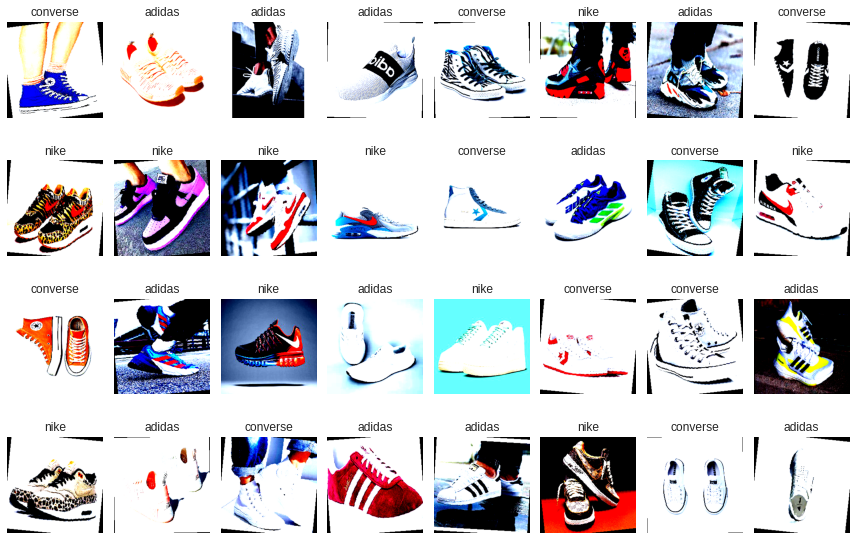

In [10]:
plt.style.use('seaborn')
rows = int(batch_size/8)
columns = int(batch_size/rows) 
plt.figure(figsize = (12, 8))
name = {0 : 'adidas', 1: 'converse', 2: 'nike'}
for i in range(images.shape[0]):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(images[i].squeeze().permute(1, 2, 0))
    plt.title(name[label[i].item()])
    plt.axis('off')
plt.tight_layout()
    

To increase the computation speed, let's use GPUs. Here we have to move few parameters to GPU, which are:
> Images and their corresponding labels. 

> Model

> Loss

Defining the device. 

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} device')

Using cuda device


### **Explaination of CNN model Architecture** 

Convolution layers are applied to extract features from the images and then fully connected neural networks has to be used to classify the classes.

I have defined my model with 3 convolution layers with 64, 128, 512 number of filters in each convolution layer respectively. 

First layer: 

> Input image size --> (3, 240, 240) 

> Convolution --> (3, 64, 3, padding = 1) i.e, (channels, no. of filters applied, kernel size)  # convolution layer mainly affects the depth(channels) of the image. It can also affect the height and width of the image but the it can be preserved by **padding**. 

> Output image size of first convolution layer will be (64, 240, 240). 

> I have used ReLU activation function which in CNN works as a normalization process. 

> Maxpooling --> (2 x 2) ie., (kernel size, stride) # Here only the height and width of the image are affected but the depth of the image will remain constant. 

> After applying maxpooling, the image size will be (64, 120, 120)

Second layer: 
> Input size --> (64, 120, 120) 

> Convolution --> (64, 128, 3)

> Output size --> (128, 120, 120).

> ReLU function.

> Maxpooling(2 x 2) output --> (128, 60, 60) 

After third layer, I will have the image of size (512, 30, 30). And I have 32 images in a batch so it will be (32, 512, 30, 30). 

> 32 * 512 * 30 * 30 flattened vector will be passed through 2 series of linear hidden layer of 512 nodes and 3 nodes with ReLU function and dropout. The final 3 nodes will have scores of adidas, nike, and converse. 


In [12]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
    self.conv2 = nn.Conv2d(64, 128, 3, padding = 1)
    self.conv3 = nn.Conv2d(128, 512, 3, padding = 1)
    self.max_pool = nn.MaxPool2d(2, 2)
    self.dropout = nn.Dropout(0.2)
    self.linear1 = nn.Linear(512 * 30 * 30, 512)
    self.linear2 = nn.Linear(512, 3)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()

  def forward(self, x): 
    x = self.max_pool(self.relu(self.conv1(x))) # input_image_size = (3, 240, 240), conv = (3, 64, 3)
    x = self.max_pool(self.relu(self.conv2(x))) # image_size = (64, 120, 120), conv = (64, 128, 3)
    x = self.max_pool(self.relu(self.conv3(x))) # image_size = (128, 60, 60), conv = (128, 512, 3)
    # image_size = (512, 30, 30) 
    x = self.dropout(x) 
    x = self.flatten(x) # 460800 size flattened image
    x = self.dropout(self.relu(self.linear1(x))) # (460800, 512)
    logits = self.linear2(x) # (512, 3)
    return logits

Instantiating the model and moving it to cuda. 

In [13]:
model = Net().to(device)

Defining the loss function and optimization technique used. **Here I have moved the loss function to cuda.**

In [14]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In the training loop, loss will be calculated and weights will be updated by backpropogating and optimization. The loop will output the training loss of the model for every 10 batches. **Here the images and their labels are moved to GPU.**

In [15]:
def train_loop(dataloader, model, criterion, optimizer):
  model.train()
  size = len(train_dataset)
  for batch, (images, label) in enumerate(train_dataloader):
    
    images = images.to(device)
    label = label.to(device)
    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, label)
    
    loss.backward()
    optimizer.step()

    if batch % 10 == 0:
      loss, current = loss.item(), batch * len(images)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


I will check the accuracy and test loss of the model by introducing new images in the test loop.  

In [16]:
def test_loop(dataloader, model, criterion,):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, labels in test_dataloader:
      images = images.to(device)
      labels = labels.to(device)
      pred = model(images)
      # print(pred)
      loss = criterion(pred, labels)
      # loss = loss.to(device)
      test_loss += loss.item()
      correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
  
  test_accuracy = test_loss/len(test_dataloader)
  # print(f'Correct: {correct}, Avg loss: {loss:>8f} \n')
  print(correct)
  correct = correct/len(test_dataloader.dataset)
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {loss:>8f} \n")

With each epoch, the optimization of the model will be done. 

In [17]:
epochs = 10
best_accuracy = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, criterion, optimizer)
    test_loop(test_dataloader, model, criterion)

print("Done!")

Epoch 1
-------------------------------
loss: 1.098307  [    0/  711]
loss: 1.087097  [  320/  711]
loss: 1.101771  [  640/  711]
38.0
Test Error: 
 Accuracy: 33.3%, Avg loss: 1.099912 

Epoch 2
-------------------------------
loss: 1.089520  [    0/  711]
loss: 1.094672  [  320/  711]
loss: 1.101916  [  640/  711]
45.0
Test Error: 
 Accuracy: 39.5%, Avg loss: 1.094444 

Epoch 3
-------------------------------
loss: 1.091351  [    0/  711]
loss: 1.084569  [  320/  711]
loss: 1.087350  [  640/  711]
38.0
Test Error: 
 Accuracy: 33.3%, Avg loss: 1.092295 

Epoch 4
-------------------------------
loss: 1.091643  [    0/  711]
loss: 1.087838  [  320/  711]
loss: 1.088479  [  640/  711]
38.0
Test Error: 
 Accuracy: 33.3%, Avg loss: 1.089969 

Epoch 5
-------------------------------
loss: 1.088947  [    0/  711]
loss: 1.101206  [  320/  711]
loss: 1.098406  [  640/  711]
45.0
Test Error: 
 Accuracy: 39.5%, Avg loss: 1.099733 

Epoch 6
-------------------------------
loss: 1.106623  [    0/  

I have obtained the highest accuracy around 50% after hyperparameter tuning. By increasing the depth of the convolutional layers and with other hyperparameter tuning, the accuracy can be increased but to use more layers, more computation and time is required. So transfer learning is my next option. 

**Transfer Learning**

It is a known fact that training on large dataset will increase the accuracy of the model to some extent but what if we have less dataset. Can we not get better accuracy at all? 

In transfer learning, the model trained on one task with large dataset will be used as a pre-trained model for classification of other task.  

Pre-trained CNN models will have convolution layers and FCNN layers. Here the convolution layers will already be optimized on a large dataset. However the output of the model will have classes corresponding to that dataset so we just need to change the FCNN layers to match our classes and optimize it. 

By using pre-trained models, the computation and time will be decreased. 

The pre-trained model I have used here is densenet121 model. It has been trained on ImageNet dataset with 1000 classes.  

In [18]:
# Instantiating pre-trained model
model1 = models.densenet121(pretrained = True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Gradients will be turned off since there is no need for optimization. 


In [19]:
for param in model1.parameters():
  param.requires_grad = False

Defining the FCNN layer. Here the gradients will be turned on automatically. 



In [23]:
classifier = nn.Sequential(nn.Linear(1024, 512), 
                     nn.ReLU(), 
                     nn.Dropout(0.2),
                     nn.Linear(512, 256), 
                     nn.ReLU(), 
                     nn.Dropout(0.2), 
                     nn.Linear(256, 3)
                     )

model1.classifier = classifier
model1.to(device)

clear_output()

Further process will be same as previous model. 

In [21]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr = 0.0001)

In [22]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model1, criterion, optimizer)
    test_loop(train_dataloader, model1, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 1.097990  [    0/  711]
loss: 1.098789  [  320/  711]
loss: 1.062644  [  640/  711]
66.0
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.048035 

Epoch 2
-------------------------------
loss: 1.044971  [    0/  711]
loss: 1.051628  [  320/  711]
loss: 1.041166  [  640/  711]
84.0
Test Error: 
 Accuracy: 73.7%, Avg loss: 0.982439 

Epoch 3
-------------------------------
loss: 0.976657  [    0/  711]
loss: 1.018716  [  320/  711]
loss: 0.905929  [  640/  711]
80.0
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.932975 

Epoch 4
-------------------------------
loss: 0.887460  [    0/  711]
loss: 0.881344  [  320/  711]
loss: 0.826885  [  640/  711]
80.0
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.873525 

Epoch 5
-------------------------------
loss: 0.819112  [    0/  711]
loss: 0.712186  [  320/  711]
loss: 0.681685  [  640/  711]
83.0
Test Error: 
 Accuracy: 72.8%, Avg loss: 0.730326 

Epoch 6
-------------------------------
loss: 0.695032  [    0/  

I have obtained the accuracy around 75% by using densenet model. The accuracy can be further improved by using other pre-trained models and hyperparameter tuning. 